In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import interpolate 
import pandas as pd 
from datetime import datetime, timedelta 

In [4]:
#Load data 
df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
df.set_index('Dates', inplace=True)

C:\Users\joshu\AppData\Local\Temp\ipykernel_7480\2695319717.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


In [5]:
df.sort_index(inplace=True)
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

f = interpolate.interp1d(df.index.astype(int), df['Prices'], kind='cubic', fill_value='extrapolate')

all_prices = f(all_dates.astype(int))

df_interpolated = pd.DataFrame({'Dates': all_dates, 'Prices': all_prices})
df_interpolated.set_index('Dates', inplace=True)



In [6]:
#Extrapolate for one more year 
future_dates = pd.date_range(start=df.index.max() + timedelta(days=1), periods=365, freq='D')
future_prices = f(future_dates.astype(int))


In [7]:
df_extrapolated = pd.DataFrame({'Dates':future_dates, 'Prices':future_prices})
df_extrapolated.set_index('Dates', inplace=True)
df_full = pd.concat([df_interpolated, df_extrapolated])


In [8]:
#Function 

def estimate_price(date):
    if isinstance(date,str):
        date = datetime.strptime(date, '%Y-%m-%d')
    if date < df_full.index.min() or date > df_full.index.max():
        return "Date out fo range"
    return df_full.loc[date, 'Prices']

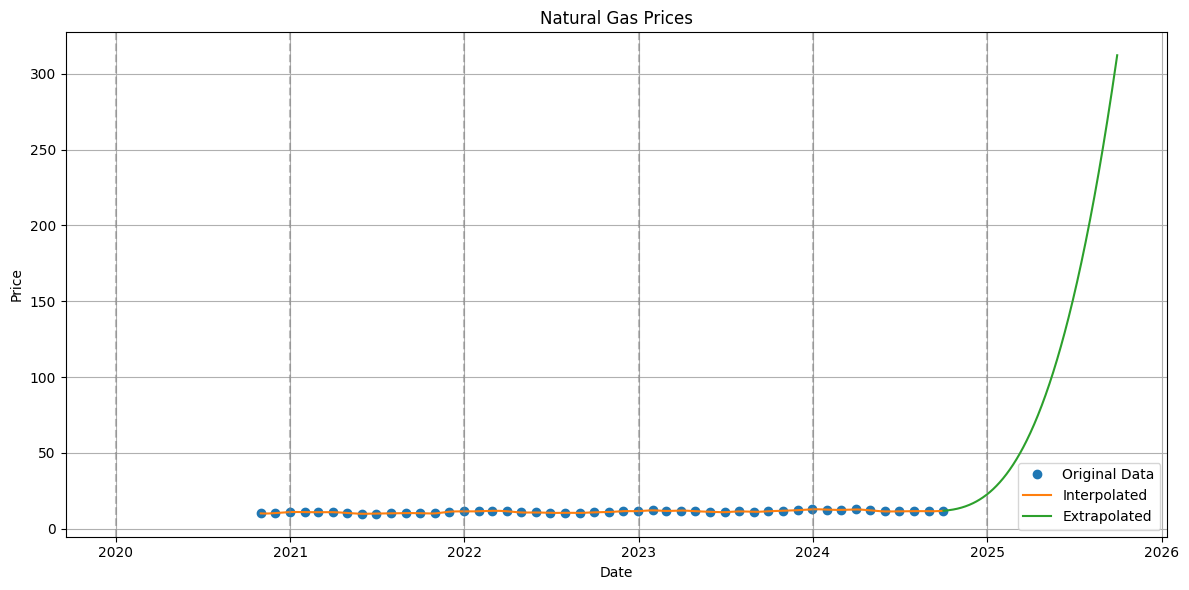

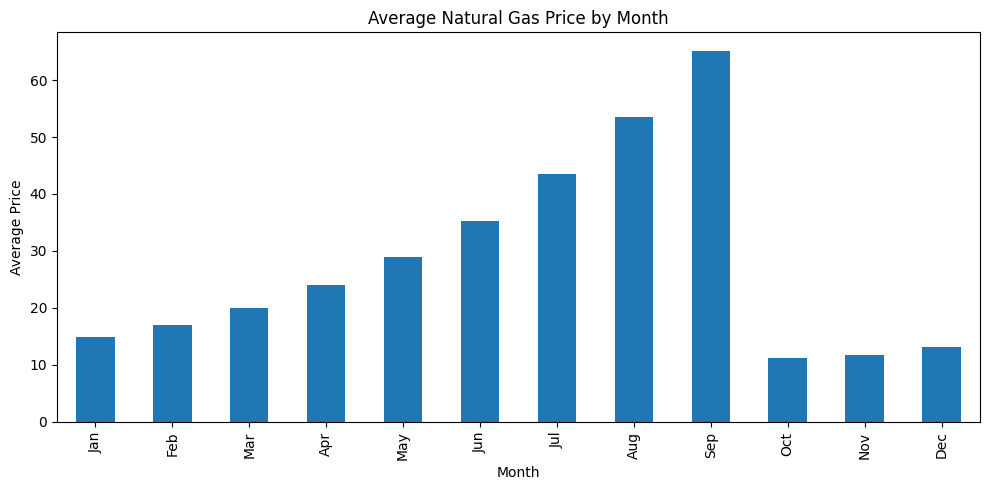

Estimated price on 2022-05-15: 10.66
Estimated price on 2023-12-31: 12.80
Estimated price on 2024-12-31: 22.58


In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Prices'], 'o', label='Original Data')
plt.plot(df_interpolated.index, df_interpolated['Prices'], label='Interpolated')
plt.plot(df_extrapolated.index, df_extrapolated['Prices'], label='Extrapolated')
plt.title('Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Add vertical lines for year boundaries
for year in range(df.index.year.min(), df_extrapolated.index.year.max() + 1):
    plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Analyze seasonal trends
df_full['Month'] = df_full.index.month
monthly_avg = df_full.groupby('Month')['Prices'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar')
plt.title('Average Natural Gas Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

# Example usage
print(f"Estimated price on 2022-05-15: {estimate_price('2022-05-15'):.2f}")
print(f"Estimated price on 2023-12-31: {estimate_price('2023-12-31'):.2f}")
print(f"Estimated price on 2024-12-31: {estimate_price('2024-12-31'):.2f}")

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Assuming we have the price estimation function from the previous code
def estimate_price(date):
    # Implementation of price estimation (as in the previous code)
    # For this example, let's return a random price between 2 and 5
    return np.random.uniform(2, 5)

In [14]:

def price_storage_contract(injection_dates, withdrawal_dates, max_injection_rate, max_withdrawal_rate, max_storage_volume, storage_cost_per_day):
   
    # Initialize variables
    current_volume = 0
    contract_value = 0
    last_date = max(max(injection_dates), max(withdrawal_dates))
    start_date = min(min(injection_dates), min(withdrawal_dates))
    
    # Create a date range for the entire contract period
    date_range = pd.date_range(start=start_date, end=last_date)
    
    for date in date_range:
        # Get the price for the current date
        price = estimate_price(date)
        if price is None:
            print(f"Warning: No price available for {date}. Skipping this date.")
            continue

        # Check if it's an injection date
        if date in injection_dates:
            volume_to_inject = min(max_injection_rate, max_storage_volume - current_volume)
            injection_cost = volume_to_inject * price
            contract_value -= injection_cost
            current_volume += volume_to_inject
        
        # Check if it's a withdrawal date
        if date in withdrawal_dates:
            volume_to_withdraw = min(max_withdrawal_rate, current_volume)
            withdrawal_revenue = volume_to_withdraw * price
            contract_value += withdrawal_revenue
            current_volume -= volume_to_withdraw
        
        # Apply daily storage cost
        contract_value -= storage_cost_per_day * current_volume
    
    return contract_value


In [16]:
# Test the function with sample inputs
injection_dates = [datetime(2023, 1, 1), datetime(2023, 2, 1), datetime(2023, 3, 1)]
withdrawal_dates = [datetime(2023, 6, 1), datetime(2023, 7, 1), datetime(2023, 8, 1)]
max_injection_rate = 100  # per day
max_withdrawal_rate = 150  # per day
max_storage_volume = 5000
storage_cost_per_day = 0.01  # per unit of gas

contract_value = price_storage_contract(
    injection_dates, withdrawal_dates,
    max_injection_rate, max_withdrawal_rate, 
    max_storage_volume, storage_cost_per_day
)

print(f"The value of the contract is: ${contract_value:.2f}")

# Test with different scenarios
# Scenario 1: More frequent injections
injection_dates_frequent = [datetime(2023, i, 1) for i in range(1, 7)]
contract_value_frequent_injection = price_storage_contract(
    injection_dates_frequent, withdrawal_dates,
    max_injection_rate, max_withdrawal_rate, 
    max_storage_volume, storage_cost_per_day
)
print(f"Contract value with more frequent injections: ${contract_value_frequent_injection:.2f}")

# Scenario 2: Lower storage costs
storage_cost_low = 0.005
contract_value_low_storage_cost = price_storage_contract(
    injection_dates, withdrawal_dates,
    max_injection_rate, max_withdrawal_rate, 
    max_storage_volume, storage_cost_low
)
print(f"Contract value with lower storage costs: ${contract_value_low_storage_cost:.2f}")

# Scenario 3: Higher max storage volume
max_storage_volume_high = 8000
contract_value_high_storage = price_storage_contract(
    injection_dates, withdrawal_dates,
    max_injection_rate, max_withdrawal_rate, 
    max_storage_volume_high, storage_cost_per_day
)
print(f"Contract value with higher max storage volume: ${contract_value_high_storage:.2f}")

The value of the contract is: $-259.26
Contract value with more frequent injections: $-1260.79
Contract value with lower storage costs: $-462.17
Contract value with higher max storage volume: $-173.53
